# UCLA Scandinavian DH Seminar, November 2017

Notebook to perform text similarity calculation and clustering for seminar hackathon.

Initial work by Matthew Wilkens, November 2017.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from   mpl_toolkits.mplot3d import Axes3D
from   nltk.corpus.reader.plaintext import PlaintextCorpusReader
from   nltk.corpus import stopwords
from   collections import defaultdict
import csv
import itertools
import numpy as np
import operator
import pandas as pd
import random
from   sklearn.cluster import KMeans, DBSCAN
from   sklearn.decomposition import PCA
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics import silhouette_samples, silhouette_score
from   sklearn.metrics.pairwise import pairwise_distances
from   sklearn.preprocessing import StandardScaler
from   IPython.display import display

In [2]:
# Additional imports if processing full input texts rather than loading derived data
from   glob import glob
import shutil

In [3]:
%matplotlib inline

corpus_name  = 'ADL'
figDir       = 'figures'
resultsDir   = 'results'
dataDir      = os.path.join('..', '..', corpus_name)
metadataFile = os.path.join(dataDir, 'metadata', 'metadata_adl.csv')
corpusDir    = os.path.join(dataDir, 'plain')

sns.set()
sns.set_context('notebook')
plt.rc('figure', figsize=(12, 8))

In [4]:
metadata = pd.read_csv(metadataFile, index_col='file_id')

In [5]:
metadata.head()

,author,title,volume,birth,death
file_id,,,,,
grundtvig11val_workid118888,N.F.S. Grundtvig,Jeg som et barn mig glæde vil,SAMLET UDGAVE,1783,1872
stuckenberg02_workid77235,Viggo Stuckenberg,For vinden danser,SAMLEDE VÆRKER,1863,1905
hauch03val_workid83908,Carsten Hauch,Sang af bajazet,UDVALGTE SKRIFTER III,1790,1872
plough01_workid56672,Carl Ploug,Vers paa bellmanske melodier,SAMLEDE DIGTE,1813,1894
hjort_02_workid54087,Knud Hjortø,Kraft,KRAFT,1869,1931


In [6]:
metadata.describe()

,birth,death
count,8787.000000,8787.000000
mean,1785.979060,1849.617048
std,89.231021,87.095092
min,0.000000,0.000000
25%,1764.000000,1826.000000
50%,1800.000000,1872.000000
75%,1863.000000,1914.000000
max,1912.000000,1938.000000


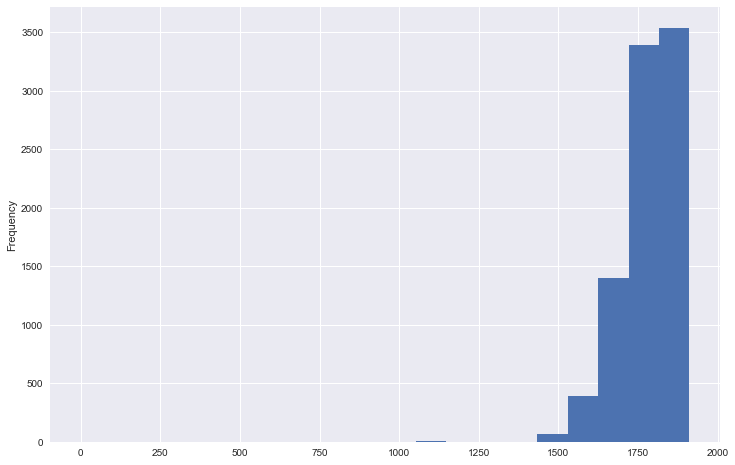

In [7]:
fig = metadata.birth.plot.hist(bins=20)

In [8]:
metadata[metadata.birth == 0]

,author,title,volume,birth,death
file_id,,,,,
larsenk_09_workid54089,kapitel,Lægemidler,DOMMENS DAG,0,0


In [9]:
md = metadata[metadata.birth != 0]

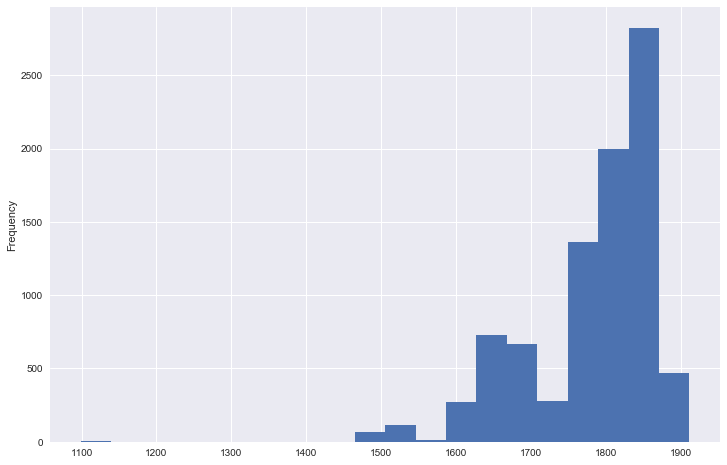

In [10]:
md.birth.plot.hist(bins=20)

In [11]:
md.author.nunique()

75

In [12]:
md.volume.nunique()

299

In [13]:
corpus = PlaintextCorpusReader(corpusDir, '.*\.txt')

In [14]:
corpus.fileids()[:5]

['Lars_workid54234.txt',
 'Lars_workid60226.txt',
 'Lars_workid63000.txt',
 'aakjaer01val_workid100074.txt',
 'aakjaer01val_workid100247.txt']

In [15]:
md[md.index == 'Lars_workid54234']

,author,title,volume,birth,death
file_id,,,,,
Lars_workid54234,Karl Larsen,Udenfor rangklasserne,Københavnerfortællinger,1860,1931


In [16]:
len(corpus.words('Lars_workid54234.txt'))

35021

In [17]:
wordcounts = {}
for fileid in corpus.fileids():
    wordcounts[fileid.strip('.txt')] = len(corpus.words(fileid))
md = md.join(pd.Series(wordcounts, name='wordcount'))

In [18]:
md.head()

,author,title,volume,birth,death,wordcount
file_id,,,,,,
grundtvig11val_workid118888,N.F.S. Grundtvig,Jeg som et barn mig glæde vil,SAMLET UDGAVE,1783,1872,340.0
stuckenberg02_workid77235,Viggo Stuckenberg,For vinden danser,SAMLEDE VÆRKER,1863,1905,131.0
hauch03val_workid83908,Carsten Hauch,Sang af bajazet,UDVALGTE SKRIFTER III,1790,1872,360.0
plough01_workid56672,Carl Ploug,Vers paa bellmanske melodier,SAMLEDE DIGTE,1813,1894,333.0
hjort_02_workid54087,Knud Hjortø,Kraft,KRAFT,1869,1931,66532.0


In [19]:
md[md.wordcount.isnull()].count()

author       30
title        22
volume       30
birth        30
death        30
wordcount     0
dtype: int64

In [20]:
md[md.wordcount > 100000].sort_values('wordcount', ascending=False)

,author,title,volume,birth,death,wordcount
file_id,,,,,,
saxoval_workid54112,Saxo,Fra piazza del popolo · i,Saxos Danmarkshistorie,1132,1208,389825.0
bergsoev01ny_workid54112,Vilhelm Bergsøe,Fra piazza del popolo · i,"Fra Piazza del Popolo · I-III<lb xml:id=""idm13...",1835,1911,298784.0
grundtvig06val_workid54333,N.F.S. Grundtvig,Hovedstrømninger. reaktionen i frankrig (1874),UDVALGTE SKRIFTER,1783,1872,251453.0
ingemann02_workid54477,B.S. Ingemann,Valdemar seier,Valdemar Seier,1789,1862,215963.0
kierkegaard03val_workid54108,Søren Kierkegaard,'at være eller ikke være.',Dagbøger i udvalg 1834-1846,1813,1855,212275.0
holberg13val_workid54110,Ludvig Holberg,Moralske tanker (dk),Moralske Tanker,1684,1754,189374.0
kidde04ny_workid54108,Harald Kidde,'at være eller ikke være.',Jærnet,1878,1918,187984.0
heibfr01_workid54096,Johanne Luise Heiberg,"Et liv genoplevet i erindringen, bind i 1812-42",Et liv genoplevet i erindringen BIND I 1812-42,1812,1890,186184.0
schandorph04_workid54192,Sophus Schandorph,Thomas fris's historie (1881),ROMANER ANDET BIND,1836,1901,185545.0


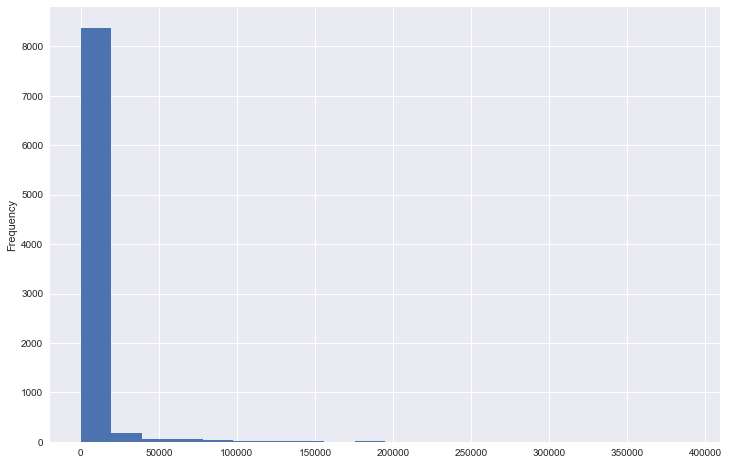

In [21]:
md.wordcount.plot.hist(bins=20)

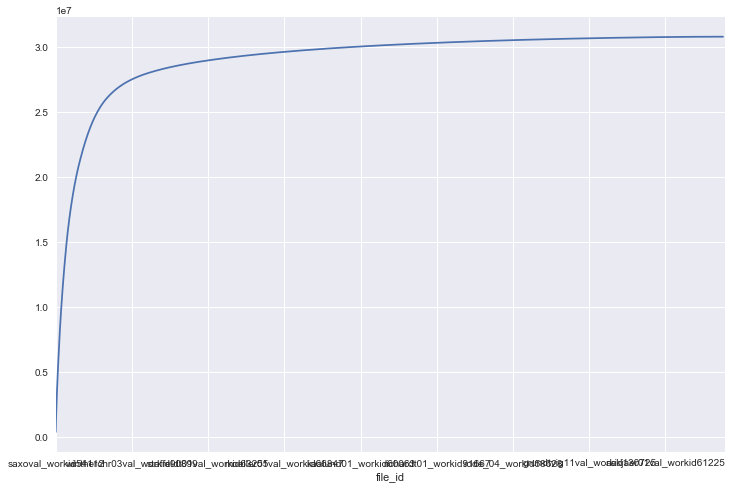

In [22]:
md.wordcount.sort_values(ascending=False).cumsum().plot()

In [23]:
md[md.wordcount >= 10000].wordcount.count()

568

In [24]:
ws = md[md.wordcount.between(100,10000)]

In [25]:
ws.describe()

,birth,death,wordcount
count,6837.000000,6837.00000,6837.000000
mean,1782.158842,1846.98669,805.230657
std,84.719538,83.77847,1356.886230
min,1485.000000,1534.00000,100.000000
25%,1743.000000,1785.00000,192.000000
50%,1798.000000,1872.00000,339.000000
75%,1861.000000,1908.00000,722.000000
max,1912.000000,1938.00000,9999.000000


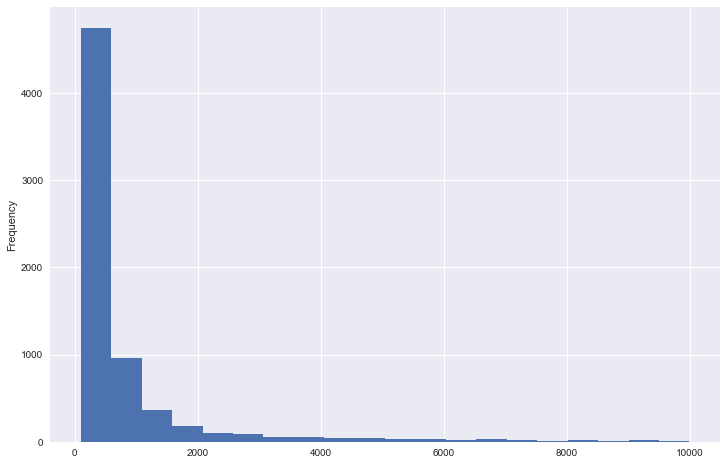

In [26]:
ws.wordcount.plot.hist(bins=20)

In [27]:
print("Total volumes with wordcount > 100 =", md.wordcount.count(), 
      "containing", md.wordcount.sum(), "words")
print("Total volumes in restricted workset = ", ws.wordcount.count(), 
      "containing", ws.wordcount.sum(), "words")

Total volumes with wordcount > 100 = 8756 containing 30820704.0 words
Total volumes in restricted workset =  6837 containing 5505362.0 words


We currently throw out long documents (over 10k), since they're likely very different from most in the corpus. But know that that throws away most of the text (31M -> 5.5M words). Something to examine on site.

In [28]:
sw = set(stopwords.words('danish'))

In [29]:
len(sw)

94

In [33]:
%%time
# Get stopword count in full corpus
stopped = defaultdict(int)
for w in corpus.words():
    if w in sw:
        stopped[w] += 1

CPU times: user 28.9 s, sys: 1.05 s, total: 30 s
Wall time: 31.2 s


In [34]:
print(stopped)

defaultdict(<class 'int'>, {'i': 520741, 'og': 815012, 'men': 116735, 'har': 132739, 'nogle': 10869, 'med': 257874, 'af': 260482, 'den': 342945, 'er': 300627, 'over': 67611, 'til': 307934, 'for': 218832, 'han': 261770, 'ikke': 229538, 'være': 52852, 'en': 345866, 'det': 420806, 'været': 21378, 'min': 73177, 'om': 143546, 'jeg': 265219, 'du': 65268, 'mig': 136022, 'ud': 57376, 'alle': 48269, 'din': 26501, 'eller': 54391, 'dem': 58570, 'ad': 16707, 'der': 213732, 'som': 302175, 'at': 474818, 'ham': 103111, 'jo': 42656, 'nu': 76291, 'dig': 34658, 'hvor': 53897, 'de': 225772, 'op': 48440, 'var': 248240, 'efter': 47536, 'hvad': 56041, 'vi': 74163, 'et': 153602, 'fra': 89909, 'ind': 40719, 'da': 97345, 'man': 61820, 'her': 42040, 'os': 40983, 'hun': 117050, 'hende': 44897, 'hendes': 32505, 'blev': 54656, 'mit': 28086, 'mange': 19418, 'denne': 43284, 'ned': 28856, 'meget': 29649, 'end': 49714, 'noget': 34719, 'hans': 80107, 'sig': 175522, 'selv': 57155, 'vil': 61783, 'mine': 17201, 'sine': 28

## Gensim

In [36]:
import gensim

In [37]:
docs = []
labels = []
for fid in ws.index:
    with open(os.path.join(corpusDir, fid+'.txt')) as f:
        txt = f.read()
    docs.append(txt)
    labels.append(fid)

In [38]:
print("Documents to process:", len(docs))

Documents to process: 6837


In [39]:
docs[0]

'No. 196.\n*)Jeg som et Barn mig glæde vil,Og sjunge i det Høie:Idag ei Sorg paa Jord er til,Som kan min Sjæl nedbøie!Idag er fattigst Betler rig!Et Paradis er Jorden mig,Guds Engle til mig kvæde:Idag er dig en Frelser fød!Idag al Jordens Sorg er død,Og født al Jordens Glæde!Ei Synd og Død i Verden meerMig knuge skal og kyse:Jeg Naadens Sol oprundet seer,Og den skal evig lyse!En Konge er idag mig fød:Det lidet Barn paa Moders SkiødAl Verdens Nød betvinger!Hans Rige Himmel er og Jord;*)\n                        Ingemanns Jule-Sang\nmed et Par Smaa-Ændringer.Den Konge evig Tro jeg svor,Og Han min Sjæl gav Vinger!Flyv høit, min Sjæl, da barnefro!Forlyst dig i Hans Rige,Med Kiærlighed, med Haab og Tro!Hans Ord skal aldrig svige!I Klude svøbt, i Krybbe lagt,Det Barn har over Stormen Magt,Og over Havets Bølger;Ei Jord, ei\n                           Luft\n, ei\n                           Ild\n, ei Vand,Ei Mørkets Magter skade kanDen Sjæl, som Barnet følger!Ei Verdens Glands og Klogskab meerF

In [40]:
# Tokenize, converting to lowercase
#  Also, remove line breaks, numbers, and one-letter words

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [41]:
# Stem. Would like to lemmatuze, but no Danish support

from nltk.stem.snowball import DanishStemmer

# Lemmatize all words in documents.
stemmer = DanishStemmer()
docs = [[stemmer.stem(token) for token in doc] for doc in docs]

In [48]:
len(docs[0])

271

In [43]:
# Compute bigrams.

from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/Users/mwilkens/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [49]:
len(docs[0])

271

In [53]:
# Remove rare and common tokens.

from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in fewer than 2 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [54]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [55]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 23647
Number of documents: 6837


In [56]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [58]:
# Train LDA model.

from gensim.models import LdaModel

# Set training parameters.
num_topics = 100
chunksize = 10000
passes = 100 # Probably higher than necessary
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
random_state = 4365

# Make an index-to-word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=random_state, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

2017-11-09 20:58:24,611 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2017-11-09 20:58:24,620 : INFO : using serial LDA version on this node
2017-11-09 20:58:38,232 : INFO : running online (multi-pass) LDA training, 100 topics, 100 passes over the supplied corpus of 6837 documents, updating model once every 6837 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence

2017-11-09 21:02:07,964 : INFO : topic #85 (0.009): 0.039*"hallo" + 0.008*"vi" + 0.007*"mod" + 0.007*"kong" + 0.006*"balthasar" + 0.005*"babylon" + 0.005*"rid" + 0.005*"vild" + 0.005*"vort" + 0.005*"sand"
2017-11-09 21:02:07,965 : INFO : topic #84 (0.009): 0.027*"hand" + 0.008*"gud" + 0.007*"och" + 0.006*"forgjæv" + 0.006*"vel" + 0.005*"sit" + 0.005*"end" + 0.005*"ja" + 0.005*"ven" + 0.005*"mand"
2017-11-09 21:02:07,968 : INFO : topic #91 (0.011): 0.012*"dig" + 0.011*"vi" + 0.008*"oc" + 0.007*"hvad" + 0.007*"vor" + 0.006*"end" + 0.005*"ei" + 0.005*"ikk" + 0.005*"os" + 0.005*"gud"
2017-11-09 21:02:07,970 : INFO : topic #76 (0.011): 0.010*"dig" + 0.009*"mod" + 0.009*"sol" + 0.008*"ej" + 0.007*"mit" + 0.006*"dit" + 0.006*"over" + 0.006*"skov" + 0.006*"jord" + 0.005*"nat"
2017-11-09 21:02:07,973 : INFO : topic #49 (0.011): 0.009*"liv" + 0.006*"mod" + 0.006*"kun" + 0.006*"vi" + 0.005*"ham" + 0.005*"hvad" + 0.005*"kan" + 0.005*"ikk" + 0.005*"blev" + 0.005*"død"
2017-11-09 21:02:07,986 : INFO

2017-11-09 21:03:52,290 : INFO : topic #84 (0.008): 0.020*"hand" + 0.010*"forgjæv" + 0.008*"etc" + 0.005*"lyksa" + 0.005*"amaryllis" + 0.005*"gud" + 0.005*"find" + 0.005*"pris" + 0.005*"sit" + 0.005*"ja"
2017-11-09 21:03:52,292 : INFO : topic #45 (0.008): 0.011*"ham" + 0.010*"vi" + 0.008*"ei" + 0.008*"ja" + 0.007*"kan" + 0.007*"os" + 0.007*"kain" + 0.006*"hvad" + 0.005*"konst" + 0.005*"folk"
2017-11-09 21:03:52,294 : INFO : topic #23 (0.012): 0.025*"gud" + 0.023*"os" + 0.019*"vi" + 0.018*"vor" + 0.017*"ei" + 0.014*"aand" + 0.014*"ord" + 0.012*"hjert" + 0.011*"liv" + 0.010*"kun"
2017-11-09 21:03:52,296 : INFO : topic #49 (0.012): 0.010*"liv" + 0.007*"mod" + 0.006*"ej" + 0.006*"kun" + 0.006*"vi" + 0.005*"ham" + 0.005*"hvad" + 0.005*"kan" + 0.005*"død" + 0.005*"blev"
2017-11-09 21:03:52,299 : INFO : topic #76 (0.014): 0.010*"mod" + 0.009*"dig" + 0.009*"sol" + 0.009*"ej" + 0.007*"over" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.005*"jord" + 0.005*"lys"
2017-11-09 21:03:52,312 : INFO : 

2017-11-09 21:05:28,071 : INFO : topic #85 (0.008): 0.039*"hallo" + 0.009*"babylon" + 0.006*"mod" + 0.006*"balthasar" + 0.005*"rid" + 0.005*"kong" + 0.004*"vild" + 0.004*"vi" + 0.004*"kom" + 0.003*"vort"
2017-11-09 21:05:28,073 : INFO : topic #84 (0.008): 0.014*"hand" + 0.011*"forgjæv" + 0.009*"etc" + 0.006*"amaryllis" + 0.005*"lyksa" + 0.005*"find" + 0.005*"pris" + 0.005*"sit" + 0.005*"mag" + 0.004*"rank"
2017-11-09 21:05:28,075 : INFO : topic #49 (0.013): 0.010*"liv" + 0.008*"ej" + 0.007*"mod" + 0.007*"kun" + 0.005*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"kan"
2017-11-09 21:05:28,077 : INFO : topic #23 (0.013): 0.027*"gud" + 0.021*"os" + 0.017*"vi" + 0.016*"vor" + 0.016*"ei" + 0.015*"aand" + 0.014*"ord" + 0.012*"hjert" + 0.011*"liv" + 0.010*"kun"
2017-11-09 21:05:28,080 : INFO : topic #76 (0.017): 0.010*"mod" + 0.010*"sol" + 0.009*"dig" + 0.008*"ej" + 0.008*"over" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.006*"lys" + 0.005*"jord"
2017-11-09 21:05

2017-11-09 21:07:00,541 : INFO : topic #85 (0.008): 0.036*"hallo" + 0.008*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"rid" + 0.004*"kong" + 0.004*"vild" + 0.004*"kom" + 0.003*"øs" + 0.003*"mand"
2017-11-09 21:07:00,544 : INFO : topic #45 (0.008): 0.011*"ham" + 0.010*"kain" + 0.009*"abel" + 0.008*"ja" + 0.006*"konst" + 0.006*"ei" + 0.006*"kan" + 0.005*"vi" + 0.005*"hvad" + 0.004*"folk"
2017-11-09 21:07:00,546 : INFO : topic #49 (0.014): 0.010*"liv" + 0.009*"ej" + 0.007*"mod" + 0.007*"kun" + 0.005*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"kan"
2017-11-09 21:07:00,549 : INFO : topic #23 (0.014): 0.028*"gud" + 0.019*"os" + 0.016*"ei" + 0.015*"vor" + 0.015*"vi" + 0.014*"ord" + 0.014*"aand" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:07:00,551 : INFO : topic #76 (0.020): 0.010*"mod" + 0.010*"sol" + 0.009*"dig" + 0.008*"over" + 0.008*"ej" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.006*"lys" + 0.005*"jord"
2017-11-09 21:07:00,564 : INF

2017-11-09 21:08:31,704 : INFO : topic #85 (0.008): 0.033*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"rid" + 0.004*"vild" + 0.004*"kong" + 0.004*"kom" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:08:31,706 : INFO : topic #84 (0.008): 0.011*"forgjæv" + 0.009*"etc" + 0.008*"hand" + 0.006*"amaryllis" + 0.005*"lyksa" + 0.005*"find" + 0.005*"mir" + 0.004*"mag" + 0.004*"rank" + 0.004*"pris"
2017-11-09 21:08:31,708 : INFO : topic #49 (0.015): 0.010*"liv" + 0.010*"ej" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"tid"
2017-11-09 21:08:31,710 : INFO : topic #23 (0.015): 0.028*"gud" + 0.017*"os" + 0.016*"ei" + 0.015*"ord" + 0.014*"vor" + 0.014*"aand" + 0.013*"vi" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:08:31,713 : INFO : topic #76 (0.024): 0.010*"sol" + 0.010*"mod" + 0.009*"dig" + 0.008*"over" + 0.008*"ej" + 0.007*"mit" + 0.006*"lys" + 0.006*"dit" + 0.006*"skov" + 0.006*"jord"
2017-11-09 21:0

2017-11-09 21:10:01,385 : INFO : topic #84 (0.007): 0.010*"forgjæv" + 0.008*"etc" + 0.006*"hand" + 0.006*"amaryllis" + 0.005*"mir" + 0.005*"find" + 0.005*"lyksa" + 0.004*"mag" + 0.004*"sit" + 0.004*"rank"
2017-11-09 21:10:01,387 : INFO : topic #85 (0.007): 0.031*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"kom" + 0.004*"vild" + 0.004*"rid" + 0.004*"kong" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:10:01,390 : INFO : topic #49 (0.016): 0.011*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"blev" + 0.005*"død" + 0.005*"tid"
2017-11-09 21:10:01,393 : INFO : topic #23 (0.016): 0.028*"gud" + 0.016*"os" + 0.016*"ei" + 0.015*"ord" + 0.014*"aand" + 0.014*"vor" + 0.012*"vi" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:10:01,395 : INFO : topic #76 (0.027): 0.010*"sol" + 0.010*"mod" + 0.009*"dig" + 0.008*"over" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:10

2017-11-09 21:11:31,397 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.005*"mir" + 0.004*"hand" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"mag" + 0.004*"rank"
2017-11-09 21:11:31,399 : INFO : topic #85 (0.007): 0.029*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.004*"balthasar" + 0.004*"kom" + 0.004*"vild" + 0.004*"kong" + 0.004*"rid" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:11:31,401 : INFO : topic #49 (0.017): 0.011*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"blev" + 0.005*"tid" + 0.005*"død"
2017-11-09 21:11:31,403 : INFO : topic #23 (0.017): 0.028*"gud" + 0.016*"ei" + 0.016*"os" + 0.015*"ord" + 0.014*"aand" + 0.013*"vor" + 0.012*"hjert" + 0.011*"vi" + 0.011*"liv" + 0.009*"død"
2017-11-09 21:11:31,406 : INFO : topic #76 (0.030): 0.010*"sol" + 0.010*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:11

2017-11-09 21:12:59,357 : INFO : topic #85 (0.007): 0.028*"hallo" + 0.006*"babylon" + 0.006*"mod" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.004*"kong" + 0.004*"rid" + 0.003*"mand" + 0.003*"vi"
2017-11-09 21:12:59,359 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"ikk" + 0.004*"mag" + 0.004*"man"
2017-11-09 21:12:59,362 : INFO : topic #23 (0.018): 0.028*"gud" + 0.016*"ei" + 0.015*"os" + 0.015*"ord" + 0.014*"aand" + 0.012*"vor" + 0.012*"hjert" + 0.011*"liv" + 0.010*"vi" + 0.009*"død"
2017-11-09 21:12:59,365 : INFO : topic #49 (0.018): 0.012*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"død"
2017-11-09 21:12:59,367 : INFO : topic #76 (0.033): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:12:59

2017-11-09 21:14:28,334 : INFO : topic #85 (0.007): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.004*"kong" + 0.003*"rid" + 0.003*"mand" + 0.003*"vi"
2017-11-09 21:14:28,337 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"ikk" + 0.004*"sit" + 0.004*"man" + 0.004*"mag"
2017-11-09 21:14:28,340 : INFO : topic #23 (0.019): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.014*"os" + 0.013*"aand" + 0.012*"vor" + 0.012*"hjert" + 0.011*"liv" + 0.010*"død" + 0.010*"vi"
2017-11-09 21:14:28,342 : INFO : topic #49 (0.019): 0.012*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:14:28,344 : INFO : topic #76 (0.036): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:14:28

2017-11-09 21:15:55,544 : INFO : topic #85 (0.007): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand" + 0.003*"ikk"
2017-11-09 21:15:55,546 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"ikk" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"man" + 0.004*"mag"
2017-11-09 21:15:55,548 : INFO : topic #23 (0.020): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.014*"os" + 0.013*"aand" + 0.012*"hjert" + 0.012*"vor" + 0.011*"liv" + 0.010*"død" + 0.009*"kun"
2017-11-09 21:15:55,551 : INFO : topic #49 (0.021): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:15:55,553 : INFO : topic #76 (0.039): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:15:

2017-11-09 21:17:22,245 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"ikk" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"man" + 0.004*"dem"
2017-11-09 21:17:22,247 : INFO : topic #85 (0.007): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:17:22,249 : INFO : topic #23 (0.020): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.013*"aand" + 0.013*"os" + 0.012*"hjert" + 0.011*"vor" + 0.011*"liv" + 0.010*"død" + 0.009*"kun"
2017-11-09 21:17:22,251 : INFO : topic #49 (0.022): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:17:22,254 : INFO : topic #76 (0.041): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"ej" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:17:

2017-11-09 21:18:48,822 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:18:48,824 : INFO : topic #45 (0.007): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"konst" + 0.005*"ikk" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kan"
2017-11-09 21:18:48,826 : INFO : topic #68 (0.021): 0.197*"vi" + 0.083*"vor" + 0.074*"os" + 0.031*"vort" + 0.007*"land" + 0.006*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"kun"
2017-11-09 21:18:48,828 : INFO : topic #49 (0.023): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:18:48,831 : INFO : topic #76 (0.044): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"ej" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:18:48,843 : I

2017-11-09 21:20:15,474 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:20:15,476 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.004*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"man"
2017-11-09 21:20:15,478 : INFO : topic #68 (0.022): 0.199*"vi" + 0.085*"vor" + 0.076*"os" + 0.031*"vort" + 0.007*"land" + 0.006*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.004*"kun"
2017-11-09 21:20:15,480 : INFO : topic #49 (0.024): 0.014*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"blev"
2017-11-09 21:20:15,482 : INFO : topic #76 (0.046): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"ej" + 0.006*"dit"
2017-11-09 21:20:1

2017-11-09 21:21:41,800 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:21:41,802 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:21:41,805 : INFO : topic #68 (0.024): 0.202*"vi" + 0.086*"vor" + 0.078*"os" + 0.032*"vort" + 0.007*"land" + 0.007*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:21:41,809 : INFO : topic #49 (0.025): 0.014*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"blev"
2017-11-09 21:21:41,811 : INFO : topic #76 (0.048): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"ej" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:23:06,588 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:23:06,590 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:23:06,592 : INFO : topic #68 (0.025): 0.204*"vi" + 0.088*"vor" + 0.080*"os" + 0.032*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:23:06,595 : INFO : topic #49 (0.026): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:23:06,597 : INFO : topic #76 (0.050): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit" + 0.005*"nat"
2017-11-09 21:23:06,612 

2017-11-09 21:24:32,377 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:24:32,379 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:24:32,381 : INFO : topic #68 (0.026): 0.207*"vi" + 0.089*"vor" + 0.082*"os" + 0.032*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:24:32,384 : INFO : topic #49 (0.027): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:24:32,386 : INFO : topic #76 (0.051): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit" + 0.006*"nat"
2017-11-09 21:24:32,399 

2017-11-09 21:25:58,265 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:25:58,267 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:25:58,269 : INFO : topic #68 (0.027): 0.209*"vi" + 0.090*"vor" + 0.083*"os" + 0.033*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:25:58,271 : INFO : topic #49 (0.028): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:25:58,273 : INFO : topic #76 (0.053): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:25:58,285 

2017-11-09 21:27:23,235 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:27:23,237 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:27:23,240 : INFO : topic #68 (0.029): 0.211*"vi" + 0.091*"vor" + 0.085*"os" + 0.033*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"lad_os" + 0.005*"mod" + 0.005*"kan"
2017-11-09 21:27:23,242 : INFO : topic #49 (0.029): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:27:23,244 : INFO : topic #76 (0.055): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:28:49,062 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:28:49,064 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:28:49,066 : INFO : topic #68 (0.030): 0.212*"vi" + 0.092*"vor" + 0.086*"os" + 0.033*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"lad_os" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:28:49,068 : INFO : topic #49 (0.030): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:28:49,070 : INFO : topic #76 (0.056): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:30:13,919 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:30:13,923 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:30:13,927 : INFO : topic #49 (0.031): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:30:13,931 : INFO : topic #68 (0.031): 0.214*"vi" + 0.093*"vor" + 0.087*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.005*"maa" + 0.005*"lad_os" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:30:13,933 : INFO : topic #76 (0.057): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:3

2017-11-09 21:31:48,566 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:31:48,568 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:31:48,570 : INFO : topic #49 (0.032): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:31:48,572 : INFO : topic #68 (0.032): 0.216*"vi" + 0.094*"vor" + 0.089*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:31:48,574 : INFO : topic #76 (0.058): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:33:13,263 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:33:13,265 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:33:13,267 : INFO : topic #49 (0.033): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:33:13,269 : INFO : topic #68 (0.033): 0.217*"vi" + 0.095*"vor" + 0.090*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:33:13,272 : INFO : topic #76 (0.059): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:34:37,068 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:34:37,071 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:34:37,073 : INFO : topic #49 (0.034): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:34:37,075 : INFO : topic #68 (0.035): 0.219*"vi" + 0.096*"vor" + 0.091*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:34:37,077 : INFO : topic #76 (0.060): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:34:37,091 

2017-11-09 21:36:00,744 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:36:00,746 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:36:00,749 : INFO : topic #49 (0.035): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:36:00,751 : INFO : topic #68 (0.036): 0.220*"vi" + 0.096*"vor" + 0.092*"os" + 0.035*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:36:00,753 : INFO : topic #76 (0.061): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:37:24,063 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:37:24,065 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:37:24,067 : INFO : topic #49 (0.035): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:37:24,069 : INFO : topic #68 (0.037): 0.222*"vi" + 0.097*"vor" + 0.093*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:37:24,071 : INFO : topic #76 (0.062): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:38:47,903 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:38:47,905 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:38:47,908 : INFO : topic #49 (0.036): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:38:47,910 : INFO : topic #68 (0.038): 0.223*"vi" + 0.098*"vor" + 0.094*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:38:47,912 : INFO : topic #76 (0.062): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:40:10,579 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:40:10,581 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:40:10,585 : INFO : topic #49 (0.037): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:40:10,587 : INFO : topic #68 (0.039): 0.225*"vi" + 0.098*"vor" + 0.095*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:40:10,589 : INFO : topic #76 (0.063): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:41:33,584 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:41:33,586 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:41:33,588 : INFO : topic #49 (0.037): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:41:33,591 : INFO : topic #68 (0.040): 0.226*"vi" + 0.099*"vor" + 0.096*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:41:33,593 : INFO : topic #76 (0.064): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:42:56,770 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:42:56,772 : INFO : topic #45 (0.005): 0.016*"kain" + 0.013*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:42:56,774 : INFO : topic #49 (0.038): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:42:56,776 : INFO : topic #68 (0.041): 0.227*"vi" + 0.100*"vor" + 0.097*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:42:56,778 : INFO : topic #76 (0.064): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:42:56,791 

2017-11-09 21:44:20,794 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:44:20,796 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:44:20,799 : INFO : topic #49 (0.039): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:44:20,801 : INFO : topic #68 (0.042): 0.228*"vi" + 0.100*"vor" + 0.097*"os" + 0.036*"vort" + 0.009*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:44:20,803 : INFO : topic #76 (0.065): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:45:44,676 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:45:44,678 : INFO : topic #45 (0.005): 0.016*"kain" + 0.013*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:45:44,680 : INFO : topic #49 (0.039): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"dig"
2017-11-09 21:45:44,682 : INFO : topic #68 (0.043): 0.230*"vi" + 0.101*"vor" + 0.098*"os" + 0.036*"vort" + 0.009*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:45:44,684 : INFO : topic #76 (0.065): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:45:44,698 

2017-11-09 21:47:08,069 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:47:08,071 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:47:08,073 : INFO : topic #49 (0.040): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"dig"
2017-11-09 21:47:08,076 : INFO : topic #68 (0.044): 0.231*"vi" + 0.101*"vor" + 0.099*"os" + 0.036*"vort" + 0.010*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:47:08,078 : INFO : topic #76 (0.066): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:48:31,509 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:48:31,511 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:48:31,513 : INFO : topic #49 (0.041): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"dig" + 0.005*"kan"
2017-11-09 21:48:31,516 : INFO : topic #68 (0.044): 0.232*"vi" + 0.102*"vor" + 0.100*"os" + 0.036*"vort" + 0.010*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"ja"
2017-11-09 21:48:31,518 : INFO : topic #76 (0.066): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:48

CPU times: user 49min 27s, sys: 1min 12s, total: 50min 40s
Wall time: 50min 34s


In [114]:
model.get_document_topics()

[(210, 0.013397734929964294),
 (223, 0.010728532979628353),
 (93, 0.008250412207897715),
 (96, 0.0080328754935023207),
 (384, 0.0076125202061442868),
 (420, 0.0074714078573052435),
 (9, 0.006738460711928412),
 (3719, 0.006566828801466828),
 (867, 0.0063774757541910495),
 (6144, 0.0059587463788194801)]

In [59]:
model.save(os.path.join(resultsDir, 'adl-topics-100'))

2017-11-10 08:03:47,364 : INFO : saving LdaState object under results/adl-topics-100.state, separately None
2017-11-10 08:03:47,583 : INFO : saved results/adl-topics-100.state
2017-11-10 08:03:47,609 : INFO : saving LdaModel object under results/adl-topics-100, separately ['expElogbeta', 'sstats']
2017-11-10 08:03:47,618 : INFO : storing np array 'expElogbeta' to results/adl-topics-100.expElogbeta.npy
2017-11-10 08:03:47,655 : INFO : not storing attribute dispatcher
2017-11-10 08:03:47,657 : INFO : not storing attribute state
2017-11-10 08:03:47,660 : INFO : not storing attribute id2word
2017-11-10 08:03:47,668 : INFO : saved results/adl-topics-100


In [61]:
model2 = LdaModel.load(os.path.join(resultsDir, 'adl-topics-100'))

2017-11-10 08:58:03,382 : INFO : loading LdaModel object from results/adl-topics-100
2017-11-10 08:58:03,393 : INFO : loading expElogbeta from results/adl-topics-100.expElogbeta.npy with mmap=None
2017-11-10 08:58:03,441 : INFO : setting ignored attribute dispatcher to None
2017-11-10 08:58:03,445 : INFO : setting ignored attribute state to None
2017-11-10 08:58:03,449 : INFO : setting ignored attribute id2word to None
2017-11-10 08:58:03,452 : INFO : loaded results/adl-topics-100
2017-11-10 08:58:03,454 : INFO : loading LdaModel object from results/adl-topics-100.state
2017-11-10 08:58:03,673 : INFO : loaded results/adl-topics-100.state


In [119]:
top_topics = model.top_topics(corpus, 20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2017-11-09 15:44:28,858 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2017-11-09 15:44:28,939 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2017-11-09 15:44:29,018 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2017-11-09 15:44:29,093 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2017-11-09 15:44:29,175 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2017-11-09 15:44:29,251 : INFO : CorpusAccumulator accumulated stats from 6000 documents


Average topic coherence: -1.3410.
[([(0.041206792815508965, 'hun'),
   (0.023902367833953962, 'hend'),
   (0.020122645684475471, 'ikk'),
   (0.017902393457686603, 'havd'),
   (0.011013036715350363, 'ham'),
   (0.0087343631992180797, 'kom'),
   (0.0083926895412983846, 'blev'),
   (0.0064394478414918771, 'over'),
   (0.0063471161158059151, 'vær'),
   (0.0057523268762379289, 'kund'),
   (0.0055309735243400529, 'ind'),
   (0.0055048244045909356, 'gik'),
   (0.0052690020517929528, 'vild'),
   (0.004937565842502753, 'mod'),
   (0.0049091339741865825, 'dem'),
   (0.0048424708493991948, 'ud'),
   (0.0046918920699783517, 'eft'),
   (0.0045719959328972314, 'op'),
   (0.0045596808723927414, 'hvad'),
   (0.0044574024637998675, 'nog')],
  -0.61320266472778451),
 ([(0.020841856476098854, 'ikk'),
   (0.011520472344709567, 'man'),
   (0.010824871452075977, 'ell'),
   (0.0092078368155213575, 'vær'),
   (0.0090436441930038282, 'kan'),
   (0.0089244819300963122, 'end'),
   (0.0086588119640938904, 'dem'),

   (0.0054805171610230749, 'lig'),
   (0.0053260840206712026, 'se')],
  -1.0327101038367545),
 ([(0.017896243074519595, 'paask'),
   (0.0096392155556067772, 'hun'),
   (0.0092884209944878015, 'lys'),
   (0.0087009822048272189, 'dag'),
   (0.0083663660212590051, 'ak'),
   (0.0054848600366178982, 'sommerdag'),
   (0.0052225778015478654, 'kys'),
   (0.0049343627644868734, 'sort'),
   (0.0048522018091786256, 'mørk'),
   (0.0047117454826940269, 'dig'),
   (0.0046621869721843318, 'stor'),
   (0.0046101582369753443, 'død'),
   (0.0046078128928019385, 'kun'),
   (0.0045544100163360836, 'liv'),
   (0.0044067209151902858, 'selv'),
   (0.0043957644064265599, 'lilj'),
   (0.0040918827171891508, 'først'),
   (0.0039871303899728329, 'tid'),
   (0.0039648003283748396, 'hvad'),
   (0.0038999090695425206, 'os')],
  -1.0502079543071396),
 ([(0.034730963812553278, 'jesu'),
   (0.018974378098733743, 'melodi'),
   (0.018126391994036047, 'mit'),
   (0.017447885032586097, 'kingo'),
   (0.01637497714256024, '